# Support Vector Machine 

Import libraries. 

In [7]:
import pandas as pd
from sklearn.metrics import auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix 

# Import data 

In [10]:
# Load the data into pandas dataframes
X_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/X_train_resampled.csv')
y_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/y_train_resampled.csv')
X_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/X_test.csv')
y_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/y_test.csv')

X_train = X_train.drop(columns='Unnamed: 0', axis=1)
y_train = y_train.drop(columns='Unnamed: 0', axis=1)
X_test = X_test.drop(columns='Unnamed: 0', axis=1)
y_test = y_test.drop(columns='Unnamed: 0', axis=1)

In [11]:
# display(y_test)
counts = y_test['VVR_group'].value_counts()
print(counts)

0    23
1    11
Name: VVR_group, dtype: int64


In [12]:
# Convert the DataFrame to a 1-dimensional NumPy array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Model with inner and outer split - SVC 

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html 

In [4]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Create the pipeline with RFE and the model
# rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
rfe = RFE(estimator=DecisionTreeClassifier())
model = SVC(probability=True)
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

param_grid = {
    'm__C': [0.1, 1, 10, 100],  # Regularization parameter
    'm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'm__gamma': ['scale', 'auto'],  # Kernel coefficient
    'm__class_weight': [{0: 0.6428571428571429, 1: 2.25}, None],  # Class weights
    's__n_features_to_select': [5, 10, 20, 40, 60, 80]  # Number of features to select with RFE
}

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, X_train_res, y_train_res, cv=outer_cv, n_jobs=2)
print(
    "The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} ± {test_score.std():.3f}"
)

# Print shape
print(X_train_res.shape)
print(y_train_res.shape)

# Fit model to training data to get best parameters
model.fit(X_train_res, y_train_res)

# Print best parameters
print(model.best_params_)

# Evaluate on the test set
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)

# Print shape
print(y_test.shape)
print(y_pred.shape)

# Print classification report 
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Calculate and print the AUC-PR
y_proba = best_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.3f}")


# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
# print(metrics.auc(fpr, tpr))

The mean score using nested cross-validation is: 0.866 ± 0.022
(112, 104)
(112,)
{'m__C': 0.1, 'm__class_weight': {0: 0.6428571428571429, 1: 2.25}, 'm__gamma': 'auto', 'm__kernel': 'poly', 's__n_features_to_select': 10}
(32,)
(32,)

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        25
           1       0.62      0.71      0.67         7

    accuracy                           0.84        32
   macro avg       0.77      0.80      0.78        32
weighted avg       0.85      0.84      0.85        32

[[22  3]
 [ 2  5]]
AUC-PR: 0.689


The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


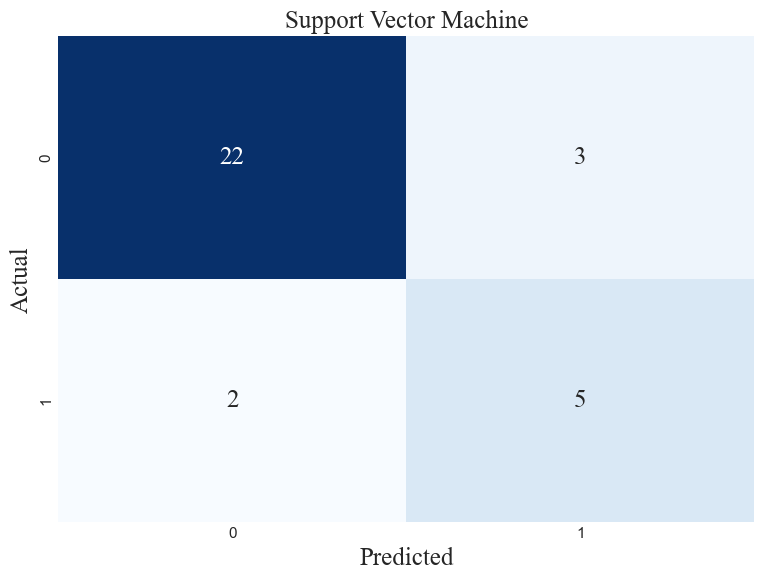

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')
# Create a custom diverging color map
colors = sns.color_palette("Blues", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('Support Vector Machine', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)

plt.show()


# Optimized model 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import seaborn as sns
from sklearn.svm import SVC

In [14]:
def build_pipeline():
    """Builds the machine learning pipeline with RFE and SVC."""
    rfe = RFE(estimator=DecisionTreeClassifier(random_state=0))  # Recursive feature elimination with a decision tree
    model = SVC(probability=True, random_state=0)  # SVC with probability estimates
    return Pipeline(steps=[('feature_selection', rfe), ('classifier', model)])  # Pipeline combining feature selection and classification

def get_param_grid():
    """Returns the hyperparameter grid for GridSearchCV."""
    return {
        'classifier__C': [0.1, 1, 10, 100],  # Regularization parameter
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
        'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],  # Kernel coefficient
        'classifier__class_weight': [{0: 0.75, 1: 1.48}, None],  # Class weights
        'feature_selection__n_features_to_select': [5, 10, 20, 40, 80]  # Number of features to select with RFE
    }

def perform_nested_cv(X, y, random_state=0):
    """Performs nested cross-validation and returns the test scores."""
    # Define the inner and outer cross-validation strategies
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
    
    pipeline = build_pipeline()  # Build the pipeline
    param_grid = get_param_grid()  # Get the hyperparameter grid
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2)
    # Perform nested cross-validation
    cv_results = cross_validate(grid_search, X, y, cv=outer_cv, n_jobs=2, return_estimator=True, return_train_score=True)
    
    test_scores = cv_results['test_score']  # Extract test scores
    test_score_mean = test_scores.mean()  # Calculate mean test score
    test_score_std = test_scores.std()  # Calculate standard deviation of test scores
    
    print(f"Test scores for each fold: {test_scores}")
    
    for idx, score in enumerate(test_scores):
        print(f"Fold {idx + 1} score: {score:.3f}, SD: {test_score_std:.3f}")  # Print score and SD for each fold
    
    print(f"The mean score using nested cross-validation is: {test_score_mean:.3f} ± {test_score_std:.3f}")
    
    # Print the best parameters for each fold
    for idx, result in enumerate(cv_results['estimator']):
        print(f"Fold {idx + 1} best parameters: {result.best_params_}")
    
    return cv_results

def plot_curves(y_test, y_proba, y_pred):
    """Plots PR and ROC curves."""
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_roc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

def evaluate_model(cv_results, X_train, y_train, X_test, y_test):
    """Evaluates the model on the test set."""
    best_estimator_per_fold = [result.best_estimator_ for result in cv_results['estimator']]  # Get best estimator for each fold
    
    # Evaluate the best model on the test set
    best_model = best_estimator_per_fold[np.argmax(cv_results['test_score'])]  # Select the best model based on test scores
    
    print("\nEvaluating best model on test set")
    y_test_pred = best_model.predict(X_test)  # Predict on the test set
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_test_pred))  # Print classification report
    conf_matrix = confusion_matrix(y_test, y_test_pred)  # Calculate confusion matrix
    print(conf_matrix)  # Print confusion matrix
    
    y_test_proba = best_model.predict_proba(X_test)[:, 1]  # Get prediction probabilities
    plot_curves(y_test, y_test_proba, y_test_pred)  # Plot PR and ROC curves
    
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    auc_pr = auc(recall, precision)
    print(f"Test AUC-PR: {auc_pr:.3f}")  # Print AUC-PR score

    return y_test_pred

Test scores for each fold: [0.85294118 0.64705882 0.94117647]
Fold 1 score: 0.853, SD: 0.123
Fold 2 score: 0.647, SD: 0.123
Fold 3 score: 0.941, SD: 0.123
The mean score using nested cross-validation is: 0.814 ± 0.123
Fold 1 best parameters: {'classifier__C': 0.1, 'classifier__class_weight': {0: 0.75, 1: 1.48}, 'classifier__gamma': 0.1, 'classifier__kernel': 'poly', 'feature_selection__n_features_to_select': 40}
Fold 2 best parameters: {'classifier__C': 1, 'classifier__class_weight': {0: 0.75, 1: 1.48}, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'feature_selection__n_features_to_select': 20}
Fold 3 best parameters: {'classifier__C': 10, 'classifier__class_weight': {0: 0.75, 1: 1.48}, 'classifier__gamma': 'auto', 'classifier__kernel': 'poly', 'feature_selection__n_features_to_select': 80}

Evaluating best model on test set

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79        23
  

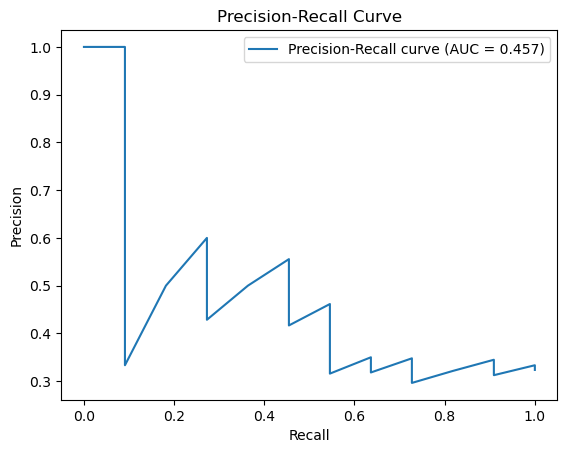

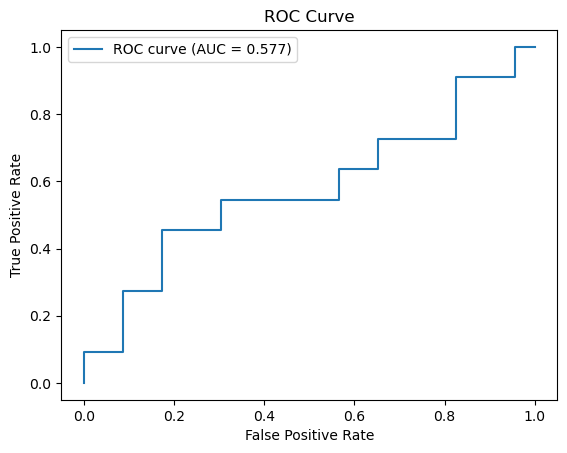

Test AUC-PR: 0.457


In [15]:
random_seed = 42

cv_results = perform_nested_cv(X_train, y_train, random_state=random_seed)  # Perform nested cross-validation
y_test_pred = evaluate_model(cv_results, X_train, y_train, X_test, y_test)  # Evaluate the model on the test set

# Confusion matrix

/var/folders/_4/nzq6mygj7j71_l3z_c9kc7wr0000gn/T/ipykernel_3807/390508903.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


Text(77.58333333333333, 0.5, 'Actual')

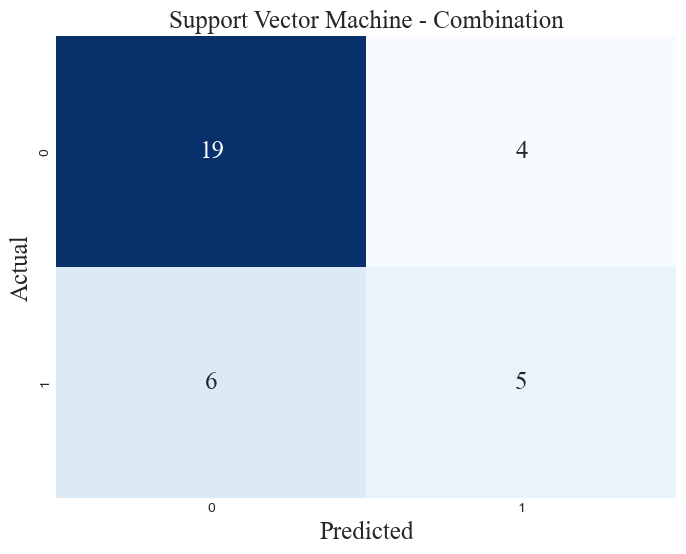

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')

# Create a custom diverging color map
colors = sns.color_palette("Blues", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('Support Vector Machine - Combination', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)

# Graph that shows Sum of VVR scores and classification 

In [17]:
pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [20]:
copy_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/copy_test_10-06-2024.csv')
display(copy_test)

,Unnamed: 0,ID,Stage,Gender,Date,Location,Condition,Faintness,Dizziness,Weakness,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,80,112,1.0,2,2021-07-04,1,1,1.0,1.0,1.0,...,-0.166497,-0.729816,2.825468,1.673580,-2.233545,0.289550,0.393906,-0.511621,1.873165,0.899641
1,62,91,1.0,1,2020-11-30,0,2,1.0,1.0,1.0,...,-0.363370,-0.080351,-0.509222,-0.565219,-0.579429,-0.022861,0.158174,0.466753,-0.568289,-0.075143
2,67,96,1.0,2,2021-09-03,0,1,1.0,1.0,1.0,...,0.567536,0.440930,0.271424,0.449194,-0.116745,0.791976,0.739793,0.129936,0.675229,0.802541
3,43,68,1.0,1,2020-09-25,1,1,1.0,1.0,1.0,...,0.187859,0.346928,-0.008672,0.055083,-0.336010,-0.518784,-0.261437,-0.190843,-0.460154,-0.433136
4,105,140,1.0,2,2021-05-26,0,3,1.0,1.0,1.0,...,-0.077072,0.440930,-0.477280,-0.360369,0.855433,0.216467,0.340371,0.202111,0.358639,0.349728
5,88,120,1.0,2,2021-04-15,1,3,1.0,1.0,1.0,...,-2.524026,-3.196200,-0.227209,-1.168774,0.725314,-1.876059,-2.751782,-2.979874,-0.123086,-1.708147
6,24,47,1.0,1,2020-07-23,1,1,1.0,1.0,1.0,...,-1.183040,0.440930,-1.648922,-1.689376,-1.010749,-0.856792,-0.593692,-0.487562,-0.978133,-0.884178
7,5,28,1.0,1,2020-02-03,0,1,1.0,1.0,1.0,...,1.024751,1.876588,2.371954,1.922297,0.497954,2.789133,1.865223,2.022527,0.775269,1.882802
8,79,111,1.0,1,2021-07-04,1,3,1.0,1.0,1.0,...,-0.333410,-1.140004,3.326447,1.972013,-2.248705,-1.876059,-2.751782,-3.390605,-3.525827,-3.577127
9,100,134,1.0,1,2021-12-05,1,3,1.0,1.0,1.0,...,0.033116,0.193108,-0.282383,-0.188178,-0.215466,-0.649872,-0.384751,-0.118668,-0.648225,-0.599438


In [18]:
display(X_test)

,Sum_1,Sum_2,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,AU02_r__variance,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,9.0,11.0,-1.954248,-0.951158,-0.794258,-2.000083,0.255940,-0.532746,-1.756362,-0.587427,...,-0.166497,-0.729816,2.825468,1.673580,-2.233545,0.289550,0.393906,-0.511621,1.873165,0.899641
1,11.0,10.0,-0.531321,-0.178666,0.044588,0.504332,-0.398439,-0.134585,-0.306588,-0.141707,...,-0.363370,-0.080351,-0.509222,-0.565219,-0.579429,-0.022861,0.158174,0.466753,-0.568289,-0.075143
2,11.0,10.0,-0.293895,0.814623,0.815957,0.504332,0.187131,0.677928,0.120579,1.064580,...,0.567536,0.440930,0.271424,0.449194,-0.116745,0.791976,0.739793,0.129936,0.675229,0.802541
3,8.0,8.0,-0.462186,-0.190678,0.033761,0.504332,-0.500519,-0.171970,0.077514,0.198167,...,0.187859,0.346928,-0.008672,0.055083,-0.336010,-0.518784,-0.261437,-0.190843,-0.460154,-0.433136
4,8.0,8.0,1.797969,2.225527,1.667268,0.504332,1.289613,1.707848,1.420513,0.971025,...,-0.077072,0.440930,-0.477280,-0.360369,0.855433,0.216467,0.340371,0.202111,0.358639,0.349728
5,10.0,10.0,0.445402,-1.535711,-2.396178,-2.893435,-0.228386,-1.431294,0.459343,-0.993773,...,-2.524026,-3.196200,-0.227209,-1.168774,0.725314,-1.876059,-2.751782,-2.979874,-0.123086,-1.708147
6,8.0,8.0,-0.310290,0.948275,0.906023,0.504332,0.274528,0.778119,-0.483465,0.164674,...,-1.183040,0.440930,-1.648922,-1.689376,-1.010749,-0.856792,-0.593692,-0.487562,-0.978133,-0.884178
7,10.0,9.0,-0.120135,1.348186,1.161928,2.036444,-0.126817,0.895732,2.359746,6.323431,...,1.024751,1.876588,2.371954,1.922297,0.497954,2.789133,1.865223,2.022527,0.775269,1.882802
8,10.0,8.0,-1.963692,-1.533310,-2.293524,-3.104972,-2.322806,-2.637824,-1.763747,-0.901456,...,-0.333410,-1.140004,3.326447,1.972013,-2.248705,-1.876059,-2.751782,-3.390605,-3.525827,-3.577127
9,11.0,8.0,1.200887,1.644948,1.340516,0.504332,1.111811,1.386446,1.132650,1.658459,...,0.033116,0.193108,-0.282383,-0.188178,-0.215466,-0.649872,-0.384751,-0.118668,-0.648225,-0.599438


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'VVR_scores': copy_test['Sum_4567'],
    'y_test': y_test,
    'y_test_pred': y_test_pred
}
df = pd.DataFrame(data)

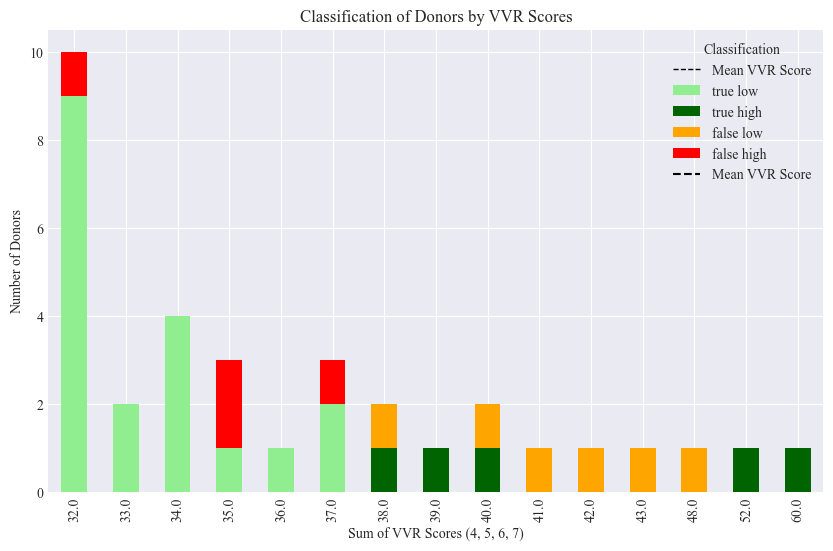

In [30]:
# Add classification labels
df['classification'] = 'false high'
df.loc[(df['y_test'] == 0) & (df['y_test_pred'] == 0), 'classification'] = 'true low'
df.loc[(df['y_test'] == 1) & (df['y_test_pred'] == 1), 'classification'] = 'true high'
df.loc[(df['y_test'] == 0) & (df['y_test_pred'] == 1), 'classification'] = 'false high'
df.loc[(df['y_test'] == 1) & (df['y_test_pred'] == 0), 'classification'] = 'false low'

# Group and count by VVR_score and classification
grouped = df.groupby(['VVR_scores', 'classification']).size().unstack(fill_value=0)

# Reorder columns to ensure "true low" and "true high" are at the bottom of the stack
grouped = grouped[['true low', 'true high', 'false low', 'false high']]

# Colors for the classifications
colors = {
    'true low': 'lightgreen',
    'true high': 'darkgreen',
    'false low': 'orange',
    'false high': 'red'
}

# Set font to Times New Roman
plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman'})

# Plot the stacked bar chart
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors.get(x) for x in grouped.columns])

# Add the mean VVR score as a vertical dotted line
mean_vvr_score = 37.62
plt.axvline(x=mean_vvr_score, color='black', linestyle='--', linewidth=1, label='Mean VVR Score')

plt.xlabel('Sum of VVR Scores (4, 5, 6, 7)')
plt.ylabel('Number of Donors')
plt.title('Classification of Donors by VVR Scores')

# Add legend
handles, labels = ax.get_legend_handles_labels()
labels.append('Mean VVR Score')
plt.legend(handles=handles, labels=labels, title='Classification')

plt.show()

# SHAP

In [6]:
import pandas as pd
import os
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,5)})
plt.style.use('fivethirtyeight')

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import shap

Using 112 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


The mean score using nested cross-validation is: 0.902 ± 0.026
{'C': 0.1, 'class_weight': {0: 0.6428571428571429, 1: 2.25}, 'gamma': 'auto', 'kernel': 'poly'}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88        25
           1       0.56      0.71      0.62         7

    accuracy                           0.81        32
   macro avg       0.73      0.78      0.75        32
weighted avg       0.83      0.81      0.82        32

[[21  4]
 [ 2  5]]
AUC-PR: 0.747


  0%|          | 0/32 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


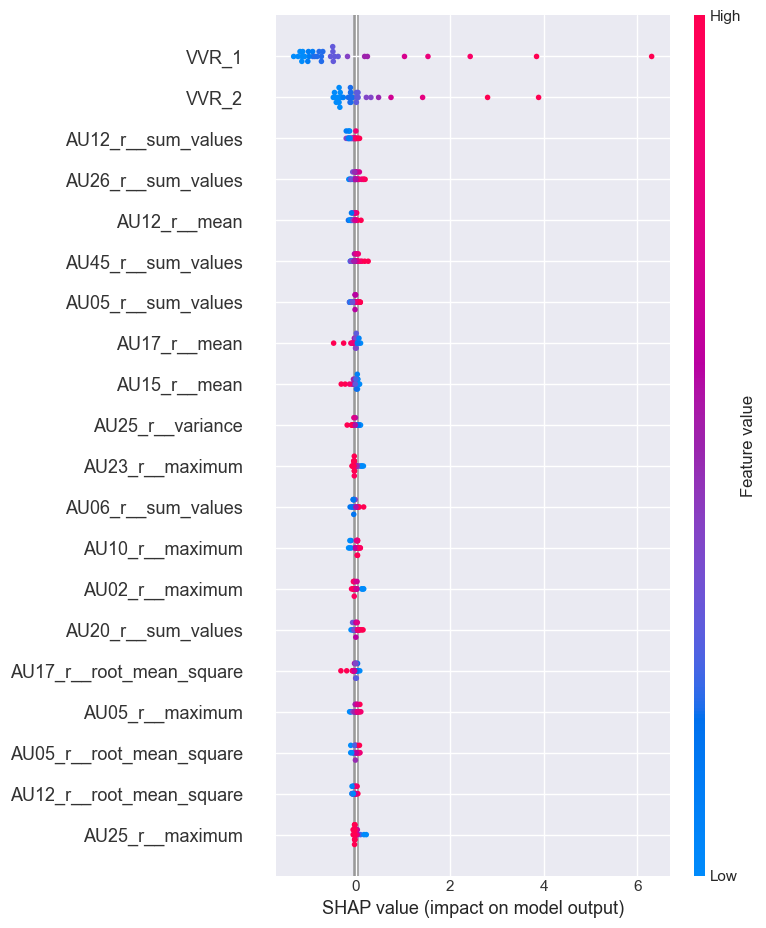

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import shap

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Create the pipeline with just the model (no RFE)
model = SVC(probability=True)

param_grid = {
    'C': [0.1],  # Regularization parameter
    'kernel': ['poly'],  # Kernel type
    'gamma': ['auto'],  # Kernel coefficient
    'class_weight': [{0: 0.6428571428571429, 1: 2.25}],  # Class weights
}

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, X_train_res, y_train_res, cv=outer_cv, n_jobs=2)
print(
    "The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} ± {test_score.std():.3f}"
)

# Fit model to training data to get best parameters
model.fit(X_train_res, y_train_res)

# Print best parameters
print(model.best_params_)

# Get the best estimator
best_model = model.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)

# Print classification report and confusion matrix
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Calculate and print the AUC-PR
y_proba = best_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.3f}")

# Use SHAP to explain the SVM model
explainer = shap.KernelExplainer(best_model.decision_function, X_train_res)
shap_values = explainer.shap_values(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, class_names=["Low VVR group", "High VVR group"])


# Error analysis

In [12]:
X_train_gender = X_train_gender.drop('Condition', axis=1)
display(X_train_gender.head(5))
display(X_test_gender.head(5))

,VVR_1,VVR_2,Gender,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,12.0,13.0,2,-0.070220,-0.403569,-0.161650,0.428359,-0.673859,-0.387663,0.994371,...,-0.537730,0.225549,-1.036133,-0.951754,-1.025247,-1.526773,-1.479742,-1.237893,-2.161830,-2.049390
1,10.0,10.0,2,2.226447,1.288304,1.124217,0.514376,0.729448,1.091318,3.433959,...,0.774622,0.458331,0.368352,0.632011,1.209277,-0.225126,-0.001447,0.619766,-0.202961,-0.127515
2,8.0,8.0,1,-0.328541,-0.286339,-0.049149,0.514376,-0.191466,-0.152619,-0.351110,...,0.539267,0.408449,0.316323,0.450683,-0.834081,-0.909004,-0.642000,0.297037,-1.125698,-0.981679
3,10.0,8.0,2,-0.179816,1.024130,0.956659,0.514376,0.292720,0.824388,-0.176376,...,0.891064,0.458331,0.480862,0.766552,-0.208294,0.810246,0.749643,0.257680,0.422548,0.743912
4,8.0,8.0,2,-0.687261,-0.791730,-0.584920,0.514376,-0.763173,-0.767495,-0.530851,...,-0.558621,0.366881,-0.858611,-0.877156,-0.419249,-0.490562,-0.230352,-0.340549,-0.573360,-0.444615


,VVR_1,VVR_2,Gender,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,10.0,11.0,1,-1.088267,-0.486929,-0.245322,-0.094909,-0.387079,-0.373556,-0.296967,...,-1.106604,-1.661648,-0.939358,-1.258986,-0.862599,0.657150,0.649175,0.619766,0.540339,0.684272
1,19.0,21.0,2,0.160204,0.681681,0.725849,0.514376,0.751085,0.775827,0.031562,...,1.791290,0.458331,1.507769,1.887518,-0.111414,0.662918,0.653014,0.478080,0.552052,0.691181
2,8.0,8.0,1,-0.510947,-0.678086,-0.451146,-0.130749,-0.740730,-0.650167,-0.512662,...,0.412202,0.458331,-0.395816,0.012935,0.703933,1.133047,0.952462,0.619766,0.765365,1.028129
3,21.0,21.0,2,1.139765,0.115481,0.300321,0.406855,0.152945,0.239720,0.621775,...,-0.009577,0.017708,-0.227168,-0.190216,1.476715,0.191834,0.323467,0.493823,0.412243,0.350324
4,11.0,8.0,1,1.257027,1.622690,1.325337,0.514376,1.084273,1.365502,1.155021,...,0.075374,0.217235,-0.256234,-0.149869,-0.194813,-0.655535,-0.383937,-0.104406,-0.685164,-0.617897


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Create the pipeline with just the model (no RFE)
model = SVC(probability=True)

param_grid = {
    'C': [0.1],  # Regularization parameter
    'kernel': ['poly'],  # Kernel type
    'gamma': ['auto'],  # Kernel coefficient
    'class_weight': [{0: 0.6428571428571429, 1: 2.25}],  # Class weights
}

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Check if 'gender' column exists in X_train_res
if 'gender' in X_train_res.columns:
    X_train_res_dropped = X_train_res.drop('gender', axis=1)
else:
    X_train_res_dropped = X_train_res

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, X_train_res_dropped, y_train_res, cv=outer_cv, n_jobs=2)
print(
    "The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} ± {test_score.std():.3f}"
)

# Fit model to training data to get best parameters
model.fit(X_train_res_dropped, y_train_res)

# Print best parameters
print(model.best_params_)

# Get the best estimator
best_model = model.best_estimator_

# Ensure 'gender' column is present in X_test
if 'gender' in X_test.columns:
    X_test_dropped = X_test_gender.drop('Gender', axis=1)
else:
    X_test_dropped = X_test

# Evaluate on the test set
y_pred = best_model.predict(X_test_dropped)

# Print classification report and confusion matrix
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Calculate and print the AUC-PR
y_proba = best_model.predict_proba(X_test_dropped)[:, 1]  # Get the probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.3f}")

# Error analysis for gender
gender_labels = X_test_gender['Gender']  # Ensure 'gender' is present in X_test_gender
male_indices = (gender_labels == 1)
female_indices = (gender_labels == 2)

# Extract true and predicted labels for male and female samples
y_test_male = y_test[male_indices]
y_pred_male = y_pred[male_indices]

y_test_female = y_test[female_indices]
y_pred_female = y_pred[female_indices]

# Generate confusion matrix for males and females
confusion_matrix_male = confusion_matrix(y_test_male, y_pred_male)
confusion_matrix_female = confusion_matrix(y_test_female, y_pred_female)

# Print confusion matrices
print("\nConfusion Matrix for Males:")
print(confusion_matrix_male)

print("\nConfusion Matrix for Females:")
print(confusion_matrix_female)

# Print classification reports for males and females
print("\nClassification Report for Males:")
print(classification_report(y_test_male, y_pred_male))

print("\nClassification Report for Females:")
print(classification_report(y_test_female, y_pred_female))



The mean score using nested cross-validation is: 0.902 ± 0.026
{'C': 0.1, 'class_weight': {0: 0.6428571428571429, 1: 2.25}, 'gamma': 'auto', 'kernel': 'poly'}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88        25
           1       0.56      0.71      0.62         7

    accuracy                           0.81        32
   macro avg       0.73      0.78      0.75        32
weighted avg       0.83      0.81      0.82        32

[[21  4]
 [ 2  5]]
AUC-PR: 0.747

Confusion Matrix for Males:
[[14  1]
 [ 2  0]]

Confusion Matrix for Females:
[[7 3]
 [0 5]]

Classification Report for Males:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.00      0.00      0.00         2

    accuracy                           0.82        17
   macro avg       0.44      0.47      0.45        17
weighted avg       0.77      0.82      0.80  

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


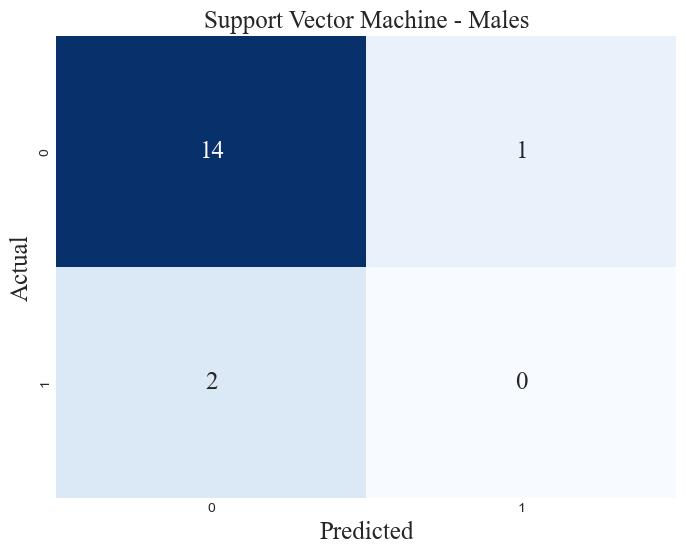

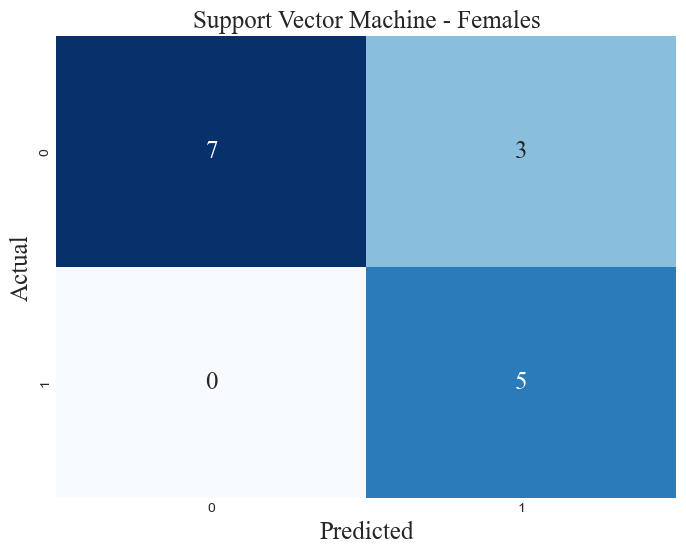

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrices for overall, males, and females
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_male = confusion_matrix(y_test_male, y_pred_male)
conf_matrix_female = confusion_matrix(y_test_female, y_pred_female)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')
# Create a custom diverging color map
colors = sns.color_palette("Blues", as_cmap=True)

# # Plot overall confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
#             annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
# plt.title('Support Vector Machine - Overall', fontname=font, fontsize=size)
# plt.xlabel('Predicted', fontname=font, fontsize=size)
# plt.ylabel('Actual', fontname=font, fontsize=size)
# plt.show()

# Plot confusion matrix for males
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_male, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('Support Vector Machine - Males', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)
plt.show()

# Plot confusion matrix for females
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_female, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('Support Vector Machine - Females', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)
plt.show()
